<a href="https://colab.research.google.com/github/whoisakshatgarg/102116084-SESS_LE1/blob/main/102116084_AkshatGarg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: **Akshat Garg**  
Email: `agarg_be21@thapar.edu`  
Roll No: **102116084**  
Group: **4CS11**  
Start Timestamp: Wed Sep 11 2024 10:00 AM

## Paper Summary

The paper "Speech Commands: A Dataset for Limited-Vocabulary Speech Recognition" by Pete Warden describes a dataset designed for training and evaluating keyword spotting systems. It outlines the dataset's creation, containing spoken words to detect specific commands, and discusses its motivation, collection process, and evaluation methodology. The dataset, released under Creative Commons BY 4.0, includes various words, background noises, and is aimed at enabling accurate, energy-efficient, on-device speech recognition models.

## Question
 Consider the paper: <https://arxiv.org/abs/1804.03209>

  1. Read and summarise the paper in about 50 words.
  2. Download the dataset in the paper, statistically analyse and
     describe it, so that it may be useful for posterity. (Include code
     snippets in your .ipynb file to evidence your analysis.)
  3. Train a classifier so that you are able to distinguish the commands
     in the dataset.
  4. Report the performance results using standard benchmarks.
  5. Record about 30 samples of each command in your voice and create a
     new dataset (including a new user id for yourself).  You may use a
     timer on your computer to synchronise.
  6. Fine tune your classifier to perform on your voice.
  7. Report the results.


## Solution

In [68]:
%matplotlib inline

In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm
!pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached pydub-0.25.1-py2.py3-none-any.whl.metadata (1.4 kB)
ERROR: Could not find a version that satisfies the requirement torch==1.7.0+cu101 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2, 

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [71]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

In [72]:
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

In [73]:
len(train_set)

84843

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


Epoch 1:   2%|▏         | 5/332 [37:57<41:22:54, 455.58s/batch]


Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


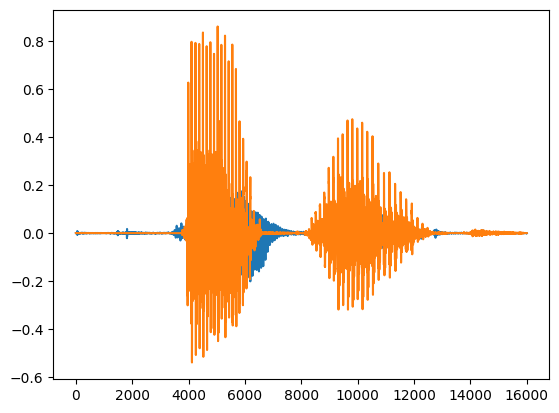

In [74]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[50]
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

waveform, sample_rate, label, speaker_id, utterance_number = train_set[25]
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

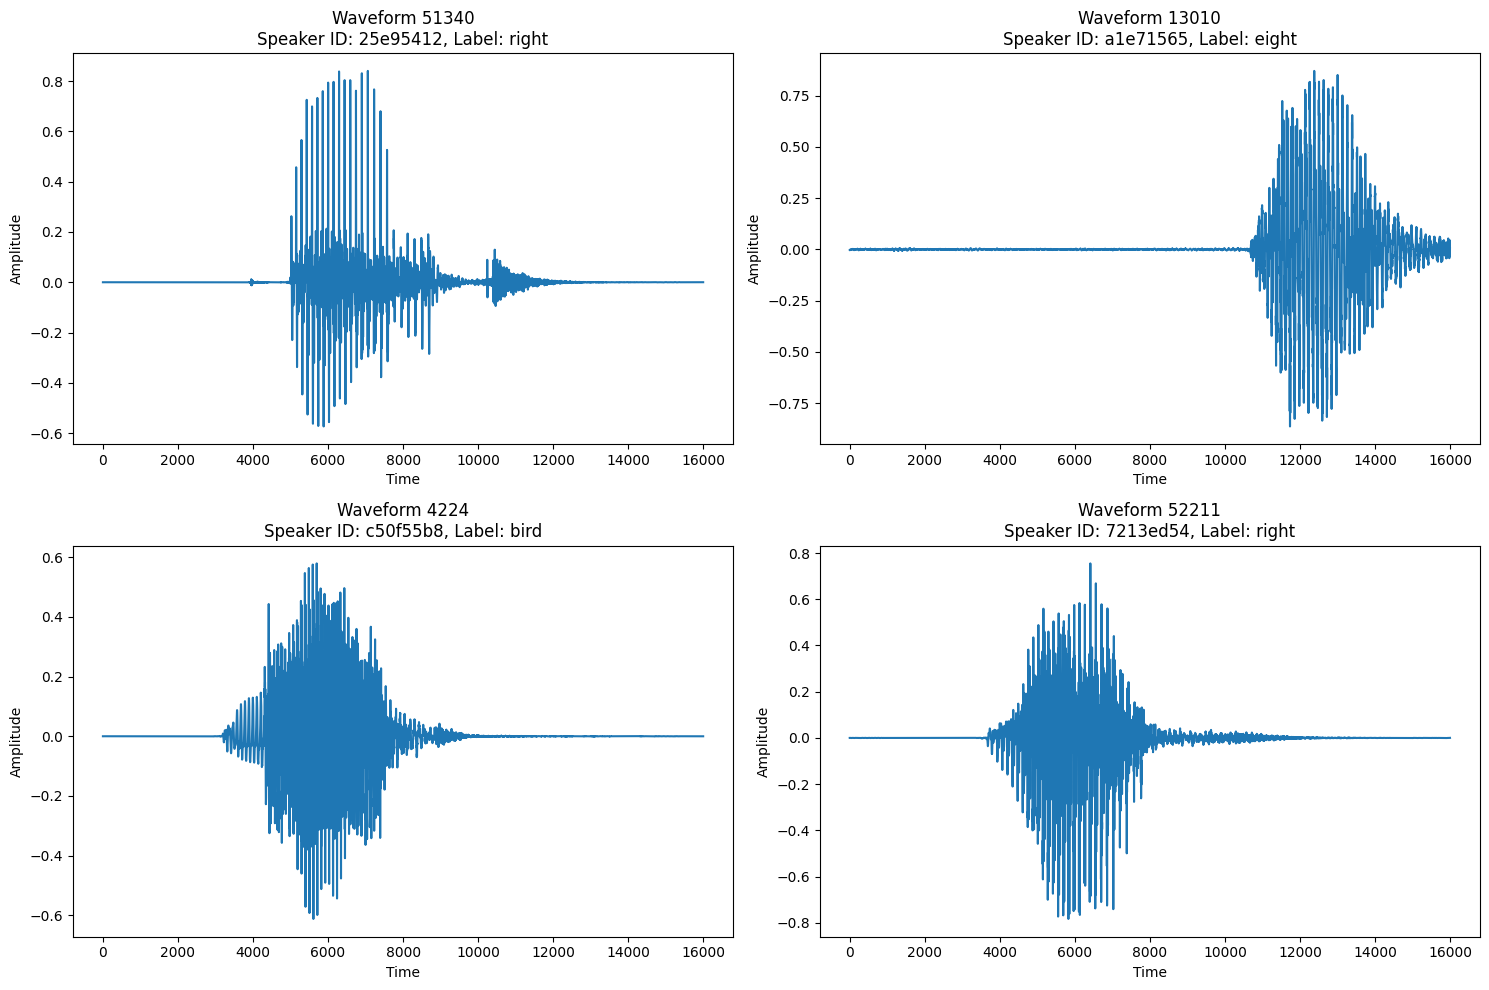

In [75]:
import random
def plot_random_waveforms(train_set, num_samples=4):
    # Randomly select num_samples from the dataset
    selected_indices = random.sample(range(len(train_set)), num_samples)

    # Create a 2x2 grid for plotting
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Flatten the 2x2 grid for easier indexing
    axs = axs.flatten()

    # Plot each selected waveform
    for i, idx in enumerate(selected_indices):
        waveform, sample_rate, label, speaker_id, utterance_number = train_set[idx]
        waveform_np = waveform.t().numpy()

        axs[i].plot(waveform_np)
        axs[i].set_title(f"Waveform {idx}\nSpeaker ID: {speaker_id}, Label: {label}")
        axs[i].set_xlabel("Time")
        axs[i].set_ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

# Call the function to plot 4 random waveforms
plot_random_waveforms(train_set)

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
from scipy.stats import describe
import tqdm

# Initialize lists to store statistics for each sample
mean_list = []
std_list = []
min_list = []
max_list = []
speaker_ids = []

# Process each sample
for i in tqdm.tqdm(range(len(train_set))):
    waveform, sample_rate, label, speaker_id, utterance_number = train_set[i]
    waveform_np = waveform.t().numpy()

    # Calculate statistics for the current sample
    mean_list.append(np.mean(waveform_np))
    std_list.append(np.std(waveform_np))
    min_list.append(np.min(waveform_np))
    max_list.append(np.max(waveform_np))
    speaker_ids.append(speaker_id)

# Convert lists to numpy arrays for easier handling
mean_list = np.array(mean_list)
std_list = np.array(std_list)
min_list = np.array(min_list)
max_list = np.array(max_list)
speaker_ids = np.array(speaker_ids)

# Aggregate statistics
overall_stats = {
    'mean': describe(mean_list),
    'std': describe(std_list),
    'min': describe(min_list),
    'max': describe(max_list)
}

100%|██████████| 84843/84843 [08:21<00:00, 169.02it/s]


Overall Statistics:

Mean:
DescribeResult(nobs=84843, minmax=(-0.23036173, 0.33127502), mean=-9.044767e-05, variance=6.016240846908551e-05, skewness=-15.945629125918895, kurtosis=541.6353986593274)

Std:
DescribeResult(nobs=84843, minmax=(0.0001796303, 0.74539423), mean=0.06969454, variance=0.002665923432397751, skewness=2.275627330265921, kurtosis=10.74368950785939)

Min:
DescribeResult(nobs=84843, minmax=(-1.0, 0.079711914), mean=-0.46494624, variance=0.07110036520295694, skewness=-0.3377616091810901, kurtosis=-0.9459128598134305)

Max:
DescribeResult(nobs=84843, minmax=(-0.18209839, 0.9999695), mean=0.46626222, variance=0.07256359452212376, skewness=0.32938595182937963, kurtosis=-0.9735917256792077)



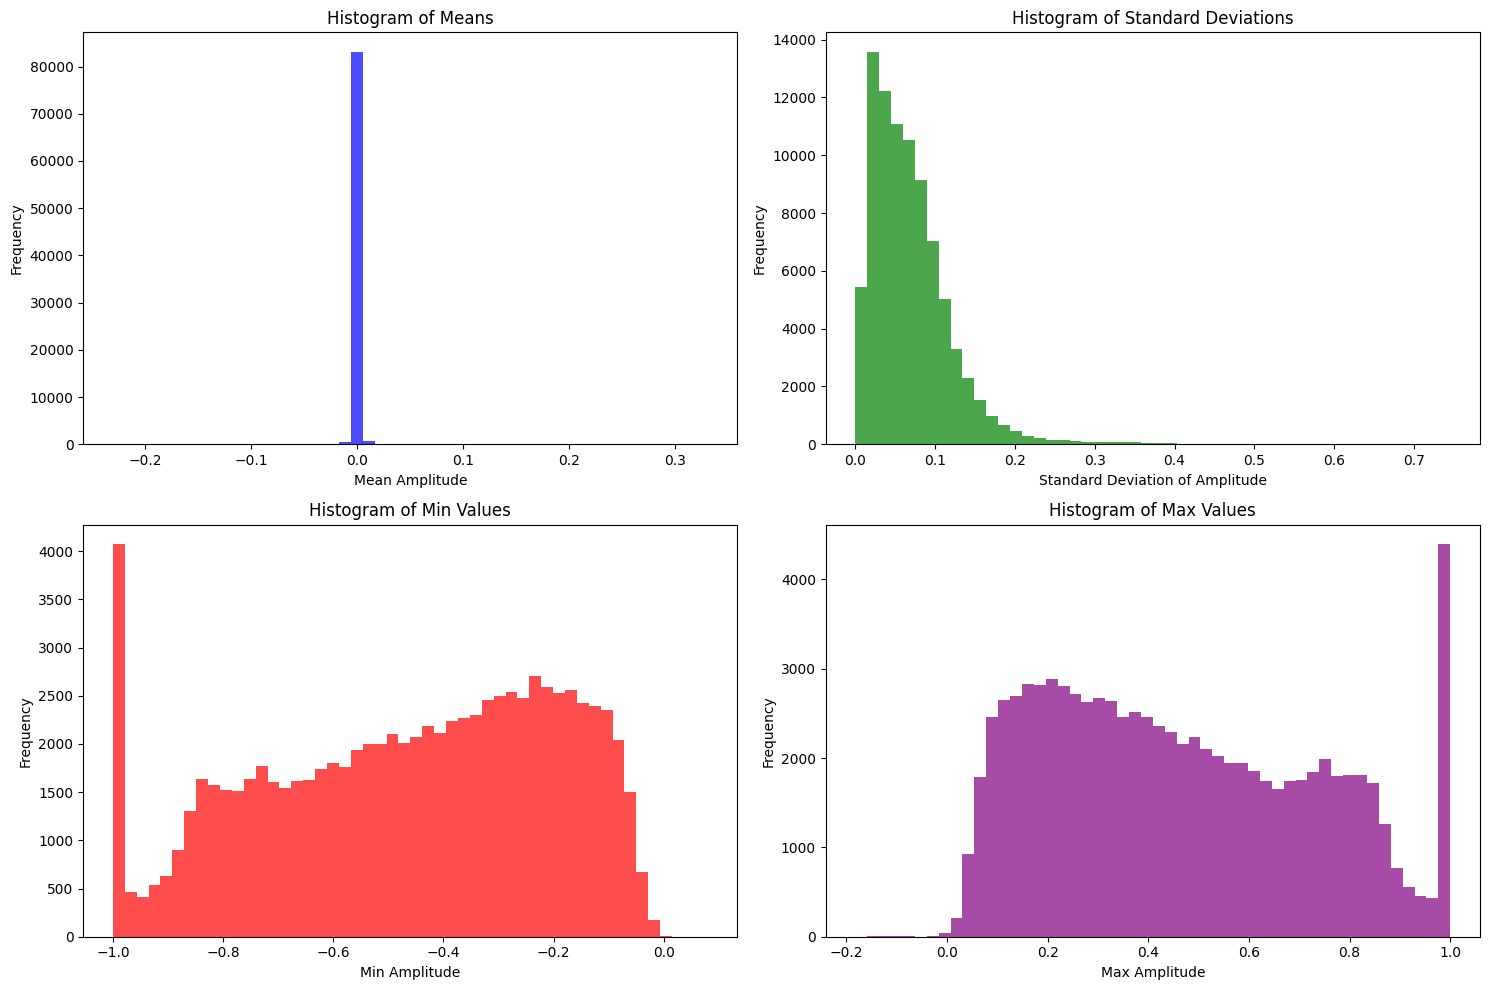

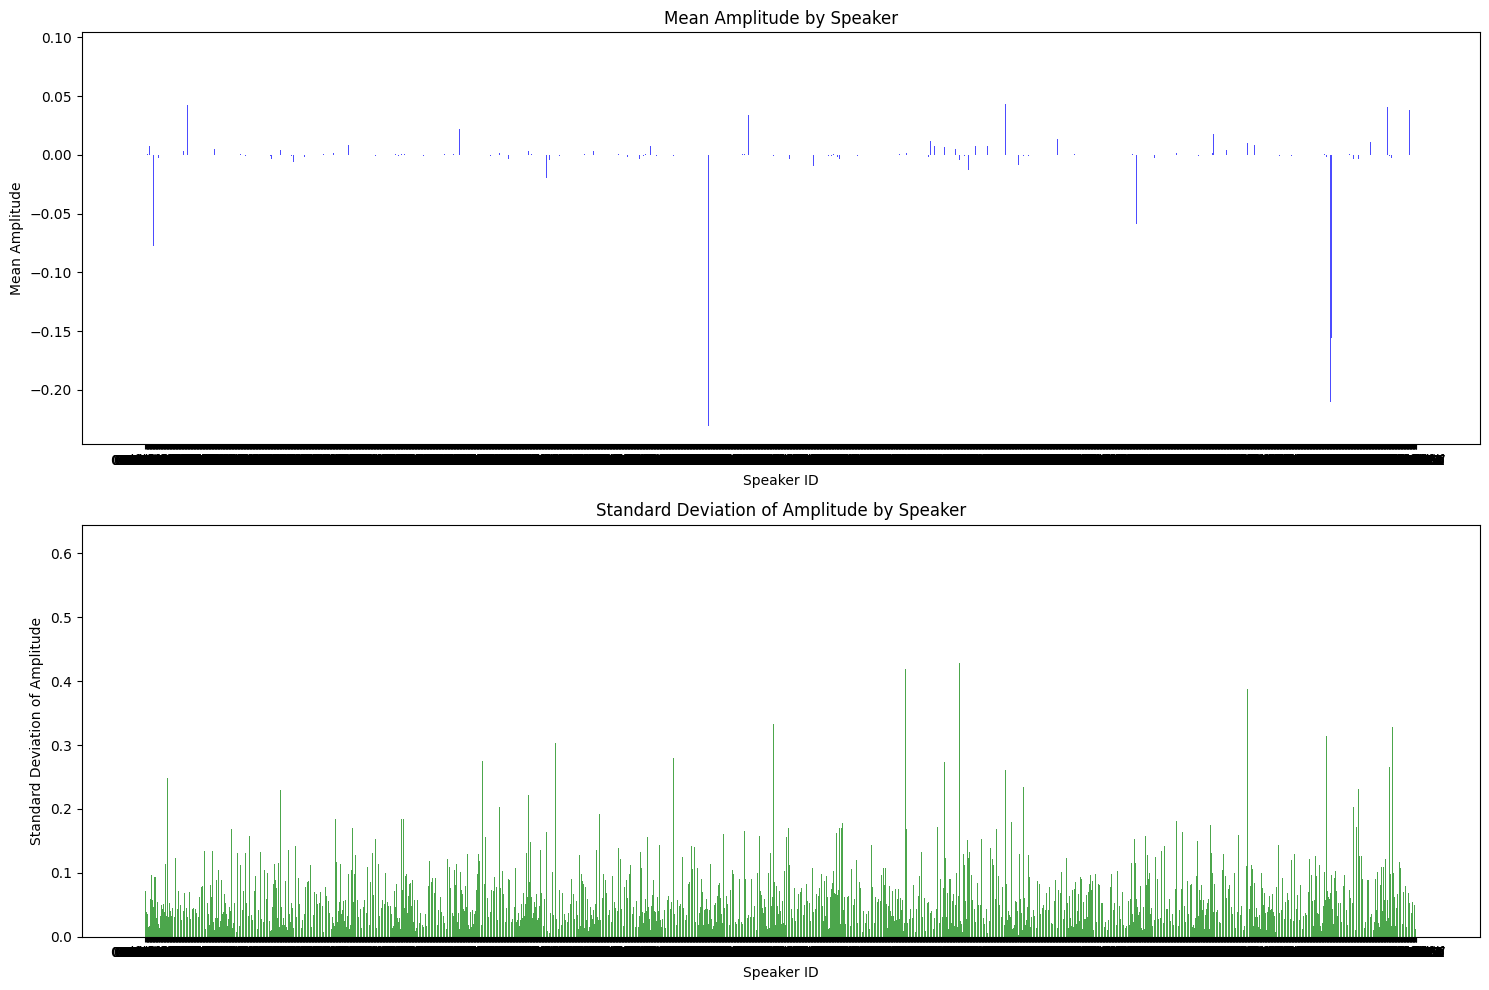

In [78]:
print("Overall Statistics:\n")
for key, stats in overall_stats.items():
    print(f"{key.capitalize()}:\n{stats}\n")
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Histogram of means
axs[0, 0].hist(mean_list, bins=50, alpha=0.7, color='blue')
axs[0, 0].set_title("Histogram of Means")
axs[0, 0].set_xlabel("Mean Amplitude")
axs[0, 0].set_ylabel("Frequency")

# Histogram of standard deviations
axs[0, 1].hist(std_list, bins=50, alpha=0.7, color='green')
axs[0, 1].set_title("Histogram of Standard Deviations")
axs[0, 1].set_xlabel("Standard Deviation of Amplitude")
axs[0, 1].set_ylabel("Frequency")

# Histogram of min values
axs[1, 0].hist(min_list, bins=50, alpha=0.7, color='red')
axs[1, 0].set_title("Histogram of Min Values")
axs[1, 0].set_xlabel("Min Amplitude")
axs[1, 0].set_ylabel("Frequency")

# Histogram of max values
axs[1, 1].hist(max_list, bins=50, alpha=0.7, color='purple')
axs[1, 1].set_title("Histogram of Max Values")
axs[1, 1].set_xlabel("Max Amplitude")
axs[1, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Analysis grouped by speaker
unique_speakers = np.unique(speaker_ids)
speaker_means = [np.mean(mean_list[speaker_ids == sp]) for sp in unique_speakers]
speaker_stds = [np.mean(std_list[speaker_ids == sp]) for sp in unique_speakers]

# Create a grid for speaker analysis
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Mean amplitude by speaker
axs[0].bar(unique_speakers, speaker_means, alpha=0.7, color='blue')
axs[0].set_title("Mean Amplitude by Speaker")
axs[0].set_xlabel("Speaker ID")
axs[0].set_ylabel("Mean Amplitude")

# Standard deviation of amplitude by speaker
axs[1].bar(unique_speakers, speaker_stds, alpha=0.7, color='green')
axs[1].set_title("Standard Deviation of Amplitude by Speaker")
axs[1].set_xlabel("Speaker ID")
axs[1].set_ylabel("Standard Deviation of Amplitude")

plt.tight_layout()
plt.show()

In [79]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

In [80]:
len(labels)

35

In [81]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

In [82]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

## Formatting the Data

In [83]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [84]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


In [85]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [86]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

In [87]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [88]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [89]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(1)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [95]:
log_interval = 20
n_epoch = 10

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm.tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

  0%|          | 0.0026666666666666666/10 [00:01<1:53:27, 680.96s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 1.042889


  1%|          | 0.05599999999999999/10 [00:39<2:00:09, 725.03s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 1.073385


  1%|          | 0.10933333333333328/10 [01:13<1:42:41, 622.91s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 0.772557


  2%|▏         | 0.16266666666666676/10 [01:55<2:06:49, 773.49s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 0.763658


  2%|▏         | 0.21600000000000033/10 [02:35<2:03:38, 758.27s/it]

Train Epoch: 1 [20480/84843 (24%)]	Loss: 0.788218


  3%|▎         | 0.2693333333333337/10 [03:14<1:57:26, 724.12s/it] 

Train Epoch: 1 [25600/84843 (30%)]	Loss: 0.779053


  3%|▎         | 0.3226666666666667/10 [03:51<1:53:02, 700.84s/it] 

Train Epoch: 1 [30720/84843 (36%)]	Loss: 0.780422


  4%|▍         | 0.3759999999999997/10 [04:29<1:46:07, 661.59s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: 0.938146


  4%|▍         | 0.42933333333333273/10 [05:07<1:46:20, 666.63s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 1.019961


  5%|▍         | 0.48266666666666574/10 [05:43<1:46:04, 668.73s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 0.846223


  5%|▌         | 0.5359999999999995/10 [06:19<1:42:34, 650.28s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 0.899591


  6%|▌         | 0.5893333333333336/10 [06:55<1:51:16, 709.43s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 0.778577


  6%|▋         | 0.6426666666666677/10 [07:30<1:40:51, 646.73s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 0.826026


  7%|▋         | 0.6960000000000018/10 [08:06<1:39:33, 642.05s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 0.916274


  7%|▋         | 0.749333333333336/10 [08:40<1:42:53, 667.35s/it] 

Train Epoch: 1 [71680/84843 (84%)]	Loss: 0.806937


  8%|▊         | 0.8026666666666701/10 [09:15<1:52:10, 731.74s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 0.727386


  9%|▊         | 0.8560000000000042/10 [09:49<1:31:30, 600.45s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 0.958360


43.885333333333335it [11:06,  1.37s/it]


Test Epoch: 1	Accuracy: 7910/11005 (72%)

Train Epoch: 2 [0/84843 (0%)]	Loss: 0.890182
Train Epoch: 2 [5120/84843 (6%)]	Loss: 0.681285


43.96533333333343it [11:58, 23.13s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 0.853159


44.0213333333335it [12:32, 49.59s/it] 

Train Epoch: 2 [15360/84843 (18%)]	Loss: 0.739040


44.09066666666692it [13:15, 133.80s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 0.763153


44.154666666667it [13:55, 404.88s/it]  

Train Epoch: 2 [25600/84843 (30%)]	Loss: 0.764095


44.208000000000396it [14:28, 583.55s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 0.561060


44.261333333333795it [15:01, 657.34s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 0.647509


44.31466666666719it [15:33, 578.51s/it]

Train Epoch: 2 [40960/84843 (48%)]	Loss: 0.858531


44.36800000000059it [16:07, 657.54s/it]

Train Epoch: 2 [46080/84843 (54%)]	Loss: 0.647784


44.42133333333399it [16:39, 593.11s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: 0.772092


44.47466666666739it [17:12, 657.13s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: 0.696083


44.52800000000079it [17:44, 586.49s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 0.678597


44.581333333334186it [18:17, 658.01s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 0.607861


44.634666666667584it [18:50, 571.48s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 0.930904


44.68800000000098it [19:23, 628.79s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.709146


44.74133333333438it [19:55, 586.02s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 0.727521


87.77066666666775it [21:12,  1.38s/it]


Test Epoch: 2	Accuracy: 8202/11005 (75%)

Train Epoch: 3 [0/84843 (0%)]	Loss: 0.624766
Train Epoch: 3 [5120/84843 (6%)]	Loss: 0.789198


87.84800000000118it [21:57, 20.28s/it]

Train Epoch: 3 [10240/84843 (12%)]	Loss: 0.676929


87.90400000000125it [22:35, 50.87s/it]

Train Epoch: 3 [15360/84843 (18%)]	Loss: 0.677621


87.97333333333466it [23:18, 133.80s/it]

Train Epoch: 3 [20480/84843 (24%)]	Loss: 0.550106


88.04000000000141it [23:58, 403.35s/it]

Train Epoch: 3 [25600/84843 (30%)]	Loss: 0.638390


88.09333333333481it [24:31, 589.18s/it]

Train Epoch: 3 [30720/84843 (36%)]	Loss: 0.727807


88.14666666666821it [25:04, 640.63s/it]

Train Epoch: 3 [35840/84843 (42%)]	Loss: 0.724898


88.20000000000161it [25:36, 593.68s/it]

Train Epoch: 3 [40960/84843 (48%)]	Loss: 0.609953


88.25333333333501it [26:07, 568.13s/it]

Train Epoch: 3 [46080/84843 (54%)]	Loss: 0.683046


88.3066666666684it [26:40, 616.68s/it] 

Train Epoch: 3 [51200/84843 (60%)]	Loss: 0.760798


88.3600000000018it [27:12, 572.88s/it] 

Train Epoch: 3 [56320/84843 (66%)]	Loss: 0.565427


88.4133333333352it [27:46, 604.41s/it] 

Train Epoch: 3 [61440/84843 (72%)]	Loss: 0.668197


88.4666666666686it [28:21, 749.76s/it] 

Train Epoch: 3 [66560/84843 (78%)]	Loss: 0.736644


88.520000000002it [28:52, 578.71s/it]  

Train Epoch: 3 [71680/84843 (84%)]	Loss: 0.721785


88.5733333333354it [29:24, 622.94s/it] 

Train Epoch: 3 [76800/84843 (90%)]	Loss: 0.733141


88.6266666666688it [29:56, 601.16s/it] 

Train Epoch: 3 [81920/84843 (96%)]	Loss: 0.759109


131.65600000000217it [31:21,  1.53s/it]


Test Epoch: 3	Accuracy: 7494/11005 (68%)

Train Epoch: 4 [0/84843 (0%)]	Loss: 0.597884
Train Epoch: 4 [5120/84843 (6%)]	Loss: 0.496970


131.72800000000225it [32:02, 18.86s/it]

Train Epoch: 4 [10240/84843 (12%)]	Loss: 0.565498


131.81600000000236it [33:04, 85.50s/it]

Train Epoch: 4 [15360/84843 (18%)]	Loss: 0.686316


131.86400000000242it [33:35, 189.42s/it]

Train Epoch: 4 [20480/84843 (24%)]	Loss: 0.674287


131.92533333333583it [34:15, 571.32s/it]

Train Epoch: 4 [25600/84843 (30%)]	Loss: 0.729713


131.97866666666923it [34:48, 618.92s/it]

Train Epoch: 4 [30720/84843 (36%)]	Loss: 0.677248


132.03200000000263it [35:23, 671.74s/it]

Train Epoch: 4 [35840/84843 (42%)]	Loss: 0.661586


132.08533333333602it [35:56, 606.73s/it]

Train Epoch: 4 [40960/84843 (48%)]	Loss: 0.631271


132.13866666666942it [36:30, 624.96s/it]

Train Epoch: 4 [46080/84843 (54%)]	Loss: 0.616947


132.19200000000282it [37:06, 692.74s/it]

Train Epoch: 4 [51200/84843 (60%)]	Loss: 0.743544


132.24533333333622it [37:39, 610.94s/it]

Train Epoch: 4 [56320/84843 (66%)]	Loss: 0.643138


132.29866666666962it [38:14, 632.08s/it]

Train Epoch: 4 [61440/84843 (72%)]	Loss: 0.869004


132.35200000000302it [38:47, 639.08s/it]

Train Epoch: 4 [66560/84843 (78%)]	Loss: 0.755343


132.40533333333642it [39:21, 617.98s/it]

Train Epoch: 4 [71680/84843 (84%)]	Loss: 0.579694


132.4586666666698it [39:55, 682.71s/it] 

Train Epoch: 4 [76800/84843 (90%)]	Loss: 0.552882


132.5120000000032it [40:28, 605.99s/it] 

Train Epoch: 4 [81920/84843 (96%)]	Loss: 0.756064


175.54133333333658it [41:48,  1.32s/it]


Test Epoch: 4	Accuracy: 8384/11005 (76%)

Train Epoch: 5 [0/84843 (0%)]	Loss: 0.486138
Train Epoch: 5 [5120/84843 (6%)]	Loss: 0.576969


175.62133333333668it [42:41, 23.44s/it]

Train Epoch: 5 [10240/84843 (12%)]	Loss: 0.588418


175.68000000000342it [43:18, 52.94s/it]

Train Epoch: 5 [15360/84843 (18%)]	Loss: 0.541127


175.7520000000035it [44:04, 139.69s/it] 

Train Epoch: 5 [20480/84843 (24%)]	Loss: 0.611178


175.81066666667024it [44:40, 355.16s/it]

Train Epoch: 5 [25600/84843 (30%)]	Loss: 0.539298


175.86400000000364it [45:14, 627.84s/it]

Train Epoch: 5 [30720/84843 (36%)]	Loss: 0.489007


175.91733333333704it [45:47, 611.89s/it]

Train Epoch: 5 [35840/84843 (42%)]	Loss: 0.640758


175.97066666667044it [46:21, 607.44s/it]

Train Epoch: 5 [40960/84843 (48%)]	Loss: 0.710971


176.02400000000384it [46:54, 585.62s/it]

Train Epoch: 5 [46080/84843 (54%)]	Loss: 0.577949


176.07733333333724it [47:27, 616.16s/it]

Train Epoch: 5 [51200/84843 (60%)]	Loss: 0.591702


176.13066666667063it [48:00, 582.77s/it]

Train Epoch: 5 [56320/84843 (66%)]	Loss: 0.747195


176.18400000000403it [48:33, 613.91s/it]

Train Epoch: 5 [61440/84843 (72%)]	Loss: 0.607719


176.23733333333743it [49:05, 558.36s/it]

Train Epoch: 5 [66560/84843 (78%)]	Loss: 0.556294


176.29066666667083it [49:37, 605.97s/it]

Train Epoch: 5 [71680/84843 (84%)]	Loss: 0.494169


176.34400000000423it [50:09, 559.76s/it]

Train Epoch: 5 [76800/84843 (90%)]	Loss: 0.400292


176.39733333333763it [50:43, 686.77s/it]

Train Epoch: 5 [81920/84843 (96%)]	Loss: 0.695315


219.426666666671it [51:58,  1.50s/it]


Test Epoch: 5	Accuracy: 8328/11005 (76%)

Train Epoch: 6 [0/84843 (0%)]	Loss: 0.466697
Train Epoch: 6 [5120/84843 (6%)]	Loss: 0.654734


219.50133333333775it [52:48, 22.43s/it]

Train Epoch: 6 [10240/84843 (12%)]	Loss: 0.594374


219.58933333333786it [53:42, 78.39s/it]

Train Epoch: 6 [15360/84843 (18%)]	Loss: 0.512675


219.6400000000046it [54:13, 181.07s/it] 

Train Epoch: 6 [20480/84843 (24%)]	Loss: 0.400160


219.69600000000466it [54:46, 472.95s/it]

Train Epoch: 6 [25600/84843 (30%)]	Loss: 0.487721


219.74933333333806it [55:20, 755.97s/it]

Train Epoch: 6 [30720/84843 (36%)]	Loss: 0.595187


219.80266666667146it [55:52, 580.00s/it]

Train Epoch: 6 [35840/84843 (42%)]	Loss: 0.720996


219.85600000000485it [56:25, 659.17s/it]

Train Epoch: 6 [40960/84843 (48%)]	Loss: 0.731696


219.90933333333825it [56:56, 574.18s/it]

Train Epoch: 6 [46080/84843 (54%)]	Loss: 0.606646


219.96266666667165it [57:29, 654.13s/it]

Train Epoch: 6 [51200/84843 (60%)]	Loss: 0.707767


220.01600000000505it [58:01, 598.38s/it]

Train Epoch: 6 [56320/84843 (66%)]	Loss: 0.503351


220.06933333333845it [58:33, 610.75s/it]

Train Epoch: 6 [61440/84843 (72%)]	Loss: 0.686881


220.12266666667185it [59:05, 600.45s/it]

Train Epoch: 6 [66560/84843 (78%)]	Loss: 0.488584


220.17600000000525it [59:36, 580.26s/it]

Train Epoch: 6 [71680/84843 (84%)]	Loss: 0.528332


220.22933333333864it [1:00:11, 623.59s/it]

Train Epoch: 6 [76800/84843 (90%)]	Loss: 0.626507


220.28266666667204it [1:00:43, 589.56s/it]

Train Epoch: 6 [81920/84843 (96%)]	Loss: 0.595320


263.3120000000054it [1:01:58,  1.30s/it]


Test Epoch: 6	Accuracy: 7998/11005 (73%)

Train Epoch: 7 [0/84843 (0%)]	Loss: 0.554917
Train Epoch: 7 [5120/84843 (6%)]	Loss: 0.725434


263.3946666666713it [1:02:47, 21.83s/it] 

Train Epoch: 7 [10240/84843 (12%)]	Loss: 0.558297


263.4533333333374it [1:03:27, 53.40s/it] 

Train Epoch: 7 [15360/84843 (18%)]	Loss: 0.569888


263.5280000000034it [1:04:13, 139.70s/it] 

Train Epoch: 7 [20480/84843 (24%)]	Loss: 0.644014


263.5760000000029it [1:04:43, 300.21s/it] 

Train Epoch: 7 [25600/84843 (30%)]	Loss: 0.497579


263.63466666666903it [1:05:19, 572.72s/it]

Train Epoch: 7 [30720/84843 (36%)]	Loss: 0.535718


263.68800000000186it [1:05:53, 620.20s/it]

Train Epoch: 7 [35840/84843 (42%)]	Loss: 0.633399


263.7413333333347it [1:06:26, 662.75s/it] 

Train Epoch: 7 [40960/84843 (48%)]	Loss: 0.546099


263.7946666666675it [1:06:58, 594.74s/it]

Train Epoch: 7 [46080/84843 (54%)]	Loss: 0.633585


263.84800000000035it [1:07:31, 648.03s/it]

Train Epoch: 7 [51200/84843 (60%)]	Loss: 0.509524


263.9013333333332it [1:08:03, 594.05s/it] 

Train Epoch: 7 [56320/84843 (66%)]	Loss: 0.585390


263.954666666666it [1:08:35, 643.88s/it] 

Train Epoch: 7 [61440/84843 (72%)]	Loss: 0.474400


264.00799999999884it [1:09:07, 587.73s/it]

Train Epoch: 7 [66560/84843 (78%)]	Loss: 0.575545


264.0613333333317it [1:09:39, 608.86s/it] 

Train Epoch: 7 [71680/84843 (84%)]	Loss: 0.417895


264.1146666666645it [1:10:12, 595.23s/it] 

Train Epoch: 7 [76800/84843 (90%)]	Loss: 0.562520


264.16799999999733it [1:10:44, 636.41s/it]

Train Epoch: 7 [81920/84843 (96%)]	Loss: 0.674172


307.1973333333304it [1:11:59,  1.29s/it]


Test Epoch: 7	Accuracy: 8832/11005 (80%)

Train Epoch: 8 [0/84843 (0%)]	Loss: 0.567953
Train Epoch: 8 [5120/84843 (6%)]	Loss: 0.607058


307.2799999999963it [1:12:46, 21.08s/it] 

Train Epoch: 8 [10240/84843 (12%)]	Loss: 0.609174


307.3386666666624it [1:13:27, 53.11s/it] 

Train Epoch: 8 [15360/84843 (18%)]	Loss: 0.479590


307.41333333332835it [1:14:12, 137.07s/it]

Train Epoch: 8 [20480/84843 (24%)]	Loss: 0.582720


307.4613333333279it [1:14:41, 294.40s/it] 

Train Epoch: 8 [25600/84843 (30%)]	Loss: 0.512249


307.519999999994it [1:15:17, 567.01s/it] 

Train Epoch: 8 [30720/84843 (36%)]	Loss: 0.483840


307.57333333332684it [1:15:50, 632.71s/it]

Train Epoch: 8 [35840/84843 (42%)]	Loss: 0.616956


307.6266666666597it [1:16:22, 577.94s/it] 

Train Epoch: 8 [40960/84843 (48%)]	Loss: 0.548851


307.6799999999925it [1:16:55, 640.14s/it] 

Train Epoch: 8 [46080/84843 (54%)]	Loss: 0.453259


307.73333333332533it [1:17:27, 586.79s/it]

Train Epoch: 8 [51200/84843 (60%)]	Loss: 0.628688


307.78666666665816it [1:18:00, 641.42s/it]

Train Epoch: 8 [56320/84843 (66%)]	Loss: 0.575781


307.839999999991it [1:18:32, 572.40s/it]  

Train Epoch: 8 [61440/84843 (72%)]	Loss: 0.635940


307.8933333333238it [1:19:06, 634.76s/it]

Train Epoch: 8 [66560/84843 (78%)]	Loss: 0.493800


307.94666666665665it [1:19:37, 576.15s/it]

Train Epoch: 8 [71680/84843 (84%)]	Loss: 0.523142


307.9999999999895it [1:20:10, 619.11s/it] 

Train Epoch: 8 [76800/84843 (90%)]	Loss: 0.664838


308.0533333333223it [1:20:44, 593.27s/it]

Train Epoch: 8 [81920/84843 (96%)]	Loss: 0.653956


351.08266666665537it [1:22:00,  1.29s/it]


Test Epoch: 8	Accuracy: 8790/11005 (80%)

Train Epoch: 9 [0/84843 (0%)]	Loss: 0.415397
Train Epoch: 9 [5120/84843 (6%)]	Loss: 0.592171


351.16533333332126it [1:22:47, 21.16s/it]

Train Epoch: 9 [10240/84843 (12%)]	Loss: 0.422332


351.22399999998737it [1:23:26, 51.94s/it]

Train Epoch: 9 [15360/84843 (18%)]	Loss: 0.564458


351.29866666665333it [1:24:12, 139.35s/it]

Train Epoch: 9 [20480/84843 (24%)]	Loss: 0.406158


351.35199999998616it [1:24:47, 344.06s/it]

Train Epoch: 9 [25600/84843 (30%)]	Loss: 0.485723


351.405333333319it [1:25:20, 574.83s/it]  

Train Epoch: 9 [30720/84843 (36%)]	Loss: 0.791319


351.4586666666518it [1:25:54, 632.63s/it]

Train Epoch: 9 [35840/84843 (42%)]	Loss: 0.521875


351.51199999998465it [1:26:26, 582.46s/it]

Train Epoch: 9 [40960/84843 (48%)]	Loss: 0.459449


351.5653333333175it [1:26:59, 614.29s/it] 

Train Epoch: 9 [46080/84843 (54%)]	Loss: 0.540858


351.6186666666503it [1:27:32, 597.65s/it] 

Train Epoch: 9 [51200/84843 (60%)]	Loss: 0.501662


351.67199999998314it [1:28:05, 611.15s/it]

Train Epoch: 9 [56320/84843 (66%)]	Loss: 0.550239


351.725333333316it [1:28:38, 631.89s/it]  

Train Epoch: 9 [61440/84843 (72%)]	Loss: 0.642362


351.7786666666488it [1:29:10, 589.04s/it] 

Train Epoch: 9 [66560/84843 (78%)]	Loss: 0.363756


351.83199999998163it [1:29:43, 644.21s/it]

Train Epoch: 9 [71680/84843 (84%)]	Loss: 0.626224


351.88533333331446it [1:30:15, 603.95s/it]

Train Epoch: 9 [76800/84843 (90%)]	Loss: 0.513379


351.9386666666473it [1:30:48, 669.74s/it] 

Train Epoch: 9 [81920/84843 (96%)]	Loss: 0.473003


394.96799999998035it [1:32:03,  1.27s/it]


Test Epoch: 9	Accuracy: 8902/11005 (81%)

Train Epoch: 10 [0/84843 (0%)]	Loss: 0.528628
Train Epoch: 10 [5120/84843 (6%)]	Loss: 0.554208


395.05066666664624it [1:32:50, 21.05s/it]

Train Epoch: 10 [10240/84843 (12%)]	Loss: 0.611619


395.10933333331235it [1:33:24, 48.28s/it]

Train Epoch: 10 [15360/84843 (18%)]	Loss: 0.576664


395.1839999999783it [1:34:14, 141.33s/it] 

Train Epoch: 10 [20480/84843 (24%)]	Loss: 0.485647


395.23733333331114it [1:34:48, 334.28s/it]

Train Epoch: 10 [25600/84843 (30%)]	Loss: 0.686511


395.290666666644it [1:35:21, 589.74s/it]  

Train Epoch: 10 [30720/84843 (36%)]	Loss: 0.682487


395.3439999999768it [1:35:55, 632.55s/it] 

Train Epoch: 10 [35840/84843 (42%)]	Loss: 0.469665


395.39733333330963it [1:36:27, 589.85s/it]

Train Epoch: 10 [40960/84843 (48%)]	Loss: 0.600733


395.45066666664246it [1:37:00, 606.61s/it]

Train Epoch: 10 [46080/84843 (54%)]	Loss: 0.635313


395.5039999999753it [1:37:33, 583.46s/it] 

Train Epoch: 10 [51200/84843 (60%)]	Loss: 0.524733


395.5573333333081it [1:38:07, 614.31s/it]

Train Epoch: 10 [56320/84843 (66%)]	Loss: 0.660358


395.61066666664095it [1:38:39, 578.46s/it]

Train Epoch: 10 [61440/84843 (72%)]	Loss: 0.461983


395.6639999999738it [1:39:21, 972.76s/it] 

Train Epoch: 10 [66560/84843 (78%)]	Loss: 0.547124


395.7173333333066it [1:40:15, 1030.91s/it] 

Train Epoch: 10 [71680/84843 (84%)]	Loss: 0.596357


395.77066666663944it [1:40:52, 601.23s/it]

Train Epoch: 10 [76800/84843 (90%)]	Loss: 0.527013


395.8239999999723it [1:41:24, 590.89s/it] 

Train Epoch: 10 [81920/84843 (96%)]	Loss: 0.489984


438.85333333330533it [1:42:40, 14.04s/it]


Test Epoch: 10	Accuracy: 8867/11005 (81%)



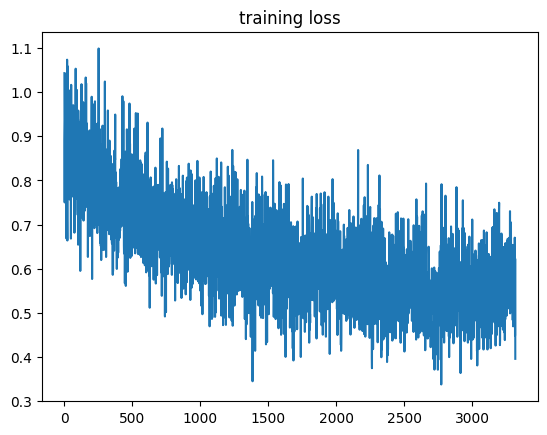

In [96]:
plt.plot(losses);
plt.title("training loss");

In [97]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: zero. Predicted: zero.


In [98]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        break
else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

Data point #1. Expected: right. Predicted: nine.
